In [230]:
import pandas as pd

df = pd.read_csv('https://raw.githubusercontent.com/maxdokukin/Politician-Trades/main/Data/data/more_prices.csv')

In [231]:
# before purchase average annualized rate of change
df['pd1'] = ((df['Price_-60_days'] / df['Price_-90_days'] - 1) / 30) * 365
df['pd2'] = ((df['Price_-40_days'] / df['Price_-60_days'] - 1)  / 20) * 365
df['pd3'] = ((df['Price_-20_days'] / df['Price_-40_days'] - 1)  / 20) * 365
df['pd4'] = ((df['Price_-10_days'] / df['Price_-20_days'] - 1)  / 10) * 365
df['pd5'] = ((df['Price_0_days'] / df['Price_-10_days'] - 1)  / 10) * 365

# before purchase average of the averages of annualized rate of change
df['pd_avg'] = df[['pd1', 'pd2', 'pd3', 'pd4', 'pd5']].sum(axis=1) / 5

# after purchase average annualized rate of change
df['fd1'] = ((df['Price_10_days'] / df['Price_0_days'] - 1)  / 10) * 365
df['fd2'] = ((df['Price_20_days'] / df['Price_10_days'] - 1)  / 10) * 365
df['fd3'] = ((df['Price_40_days'] / df['Price_20_days'] - 1)  / 20) * 365
df['fd4'] = ((df['Price_60_days'] / df['Price_40_days'] - 1)  / 20) * 365
df['fd5'] = ((df['Price_90_days'] / df['Price_60_days'] - 1)  / 30) * 365

# after purchase average of the averages of annualized rate of change
df['fd_avg'] = df[['fd1', 'fd2', 'fd3', 'fd4', 'fd5']].sum(axis=1) / 5

# delta of average before and after purchase performances
df['perf_delta'] = df['fd_avg'] - df['pd_avg']

In [232]:
df.loc[df['Transaction Type'] == 'RECEIVE', 'Transaction Type'] = 'BUY'
df.drop(df[df['Transaction Type'] == 'EXCHANGE'].index, inplace=True)
df.drop(df[df['Party'] == 'Other'].index, inplace=True)

In [233]:
def market_figure(row):
    if row.pd_avg <= 0 and row.fd_avg <= 0:
        return 'CTS_DOWN'
    elif row.pd_avg >= 0 and row.fd_avg >= 0:
        return 'CTS_UP'
    elif row.pd_avg > 0 and row.fd_avg < 0:
        return 'PEAK'
    elif row.pd_avg < 0 and row.fd_avg > 0:
        return 'DIP'

df['market_figure'] = df.apply(market_figure, axis=1)
df['market_figure'].value_counts()

market_figure
DIP         9562
CTS_DOWN    7702
CTS_UP      7604
PEAK        6702
Name: count, dtype: int64

In [234]:
def eval_success(row):
    decision_map = {
        ('CTS_DOWN', 'SELL'): 'Good Decision',
        ('CTS_UP', 'SELL'): 'Bad Decision',
        ('PEAK', 'SELL'): 'Very Good Decision',
        ('DIP', 'SELL'): 'Very Bad Decision',
        ('CTS_DOWN', 'BUY'): 'Bad Decision',
        ('CTS_UP', 'BUY'): 'Good Decision',
        ('PEAK', 'BUY'): 'Very Bad Decision',
        ('DIP', 'BUY'): 'Very Good Decision'
    }
    return decision_map[(row['market_figure'], row['Transaction Type'])]

df['transaction_eval'] = df.apply(eval_success, axis=1)
df['transaction_eval'].value_counts()

transaction_eval
Very Bad Decision     8210
Very Good Decision    8054
Good Decision         7857
Bad Decision          7449
Name: count, dtype: int64

In [235]:
politician_decisions = df.groupby('Politician Name')['transaction_eval'].value_counts().reset_index()

total_trades = df.groupby('Politician Name')['Chamber'].count().reset_index()

palt = politician_decisions.merge(total_trades, on = 'Politician Name')
palt['proportion'] = palt['count'] / palt['Chamber'] * 100

palt = palt.merge(df[['Politician Name', 'Party']], on='Politician Name')
palt

,Politician Name,transaction_eval,count,Chamber,proportion,Party
0,Adam Schiff,Very Good Decision,1,2,50.000000,Democrat
1,Adam Schiff,Very Good Decision,1,2,50.000000,Democrat
2,Adam Schiff,Bad Decision,1,2,50.000000,Democrat
3,Adam Schiff,Bad Decision,1,2,50.000000,Democrat
4,Alan Lowenthal,Very Bad Decision,44,139,31.654676,Democrat
...,...,...,...,...,...,...
125773,Zoe Lofgren,Very Good Decision,25,164,15.243902,Democrat
125774,Zoe Lofgren,Very Good Decision,25,164,15.243902,Democrat
125775,Zoe Lofgren,Very Good Decision,25,164,15.243902,Democrat
125776,Zoe Lofgren,Very Good Decision,25,164,15.243902,Democrat


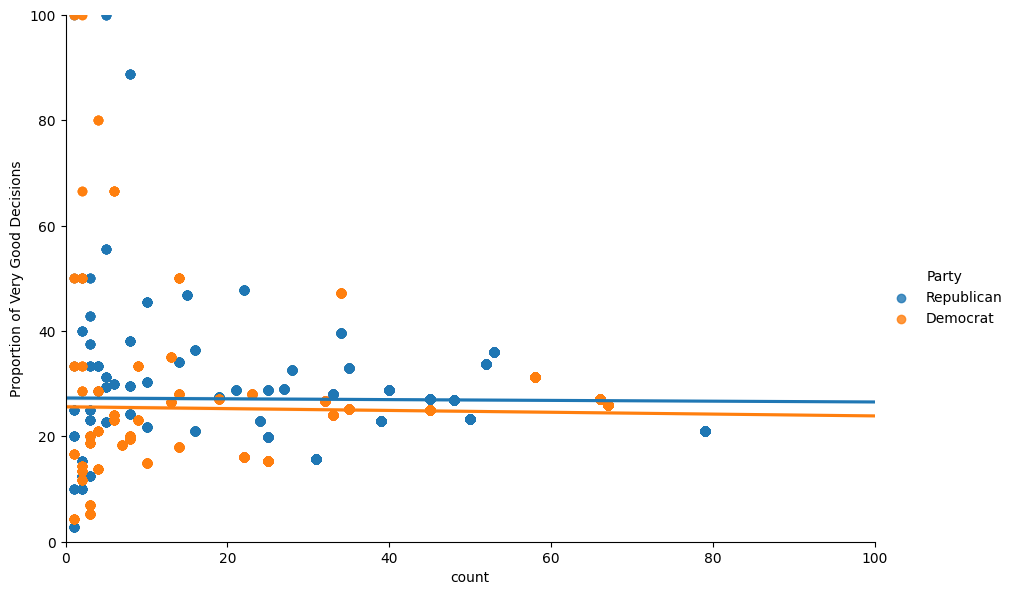

In [236]:
plot_data = palt[palt['transaction_eval'] == 'Very Good Decision'].sort_values('proportion', ascending=False)
plot_data = plot_data[plot_data['count'] < 500]

# sns.lmplot(data=plot_data, x='count', y='proportion', hue='Party', order=4, truncate=False, height=6, aspect=1.5)
sns.lmplot(data=plot_data, x='count', y='proportion', hue='Party', order=1, truncate=False, height=6, aspect=1.5)

plt.xlim(0, 100)
plt.ylim(0, 100)
plt.ylabel('Proportion of Very Good Decisions')
plt.show()

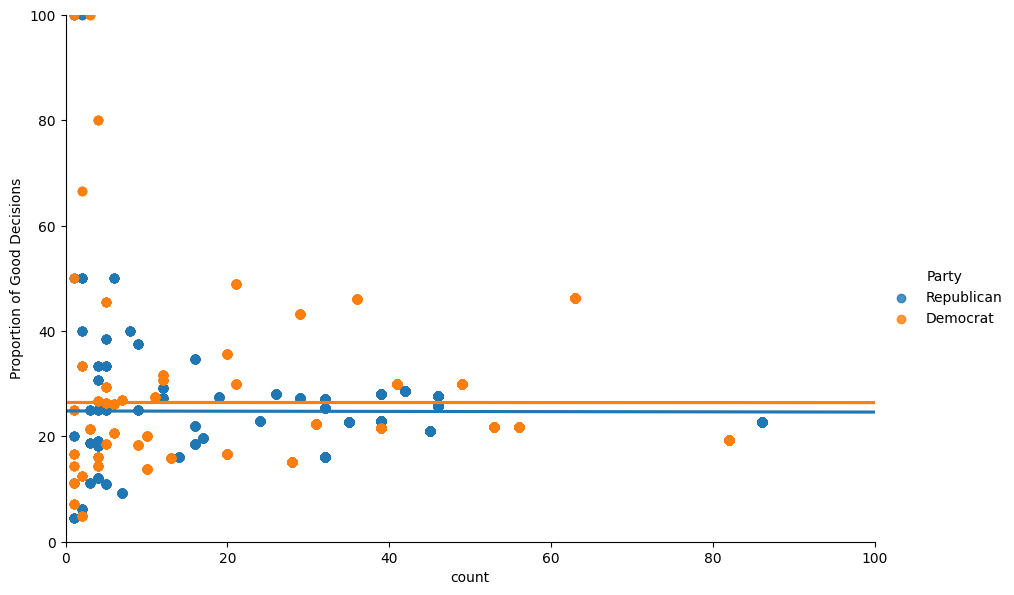

In [237]:
plot_data = palt[palt['transaction_eval'] == 'Good Decision'].sort_values('proportion', ascending=False)
sns.lmplot(data=plot_data, x='count', y='proportion', hue='Party', truncate=False, height=6, aspect=1.5)

plt.xlim(0, 100)
plt.ylim(0, 100)
plt.ylabel('Proportion of Good Decisions')
plt.show()

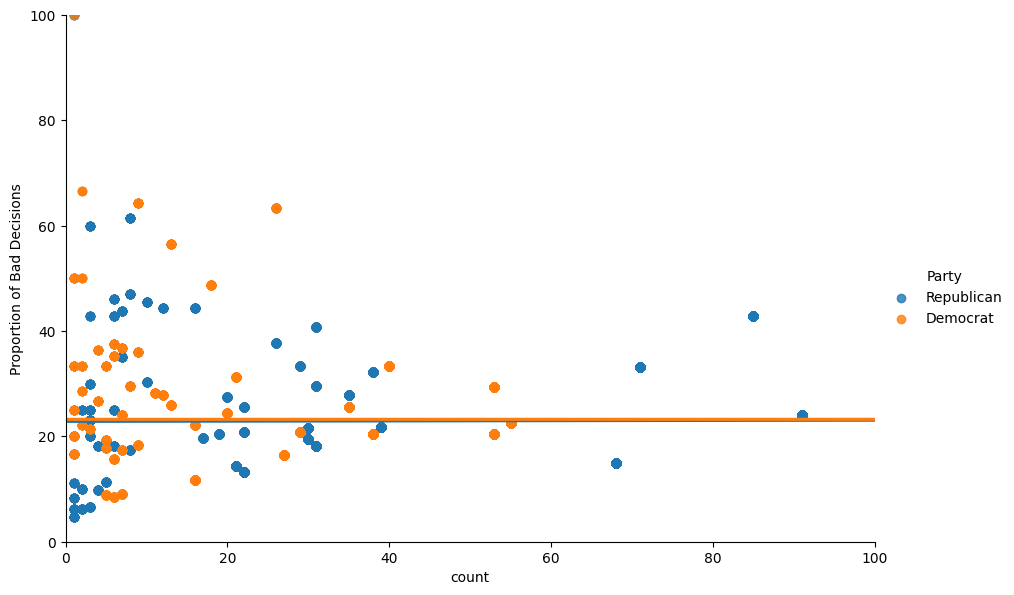

In [238]:
plot_data = palt[palt['transaction_eval'] == 'Bad Decision'].sort_values('proportion', ascending=False)
sns.lmplot(data=plot_data, x='count', y='proportion', hue='Party', truncate=False, height=6, aspect=1.5)

plt.xlim(0, 100)
plt.ylim(0, 100)
plt.ylabel('Proportion of Bad Decisions')
plt.show()

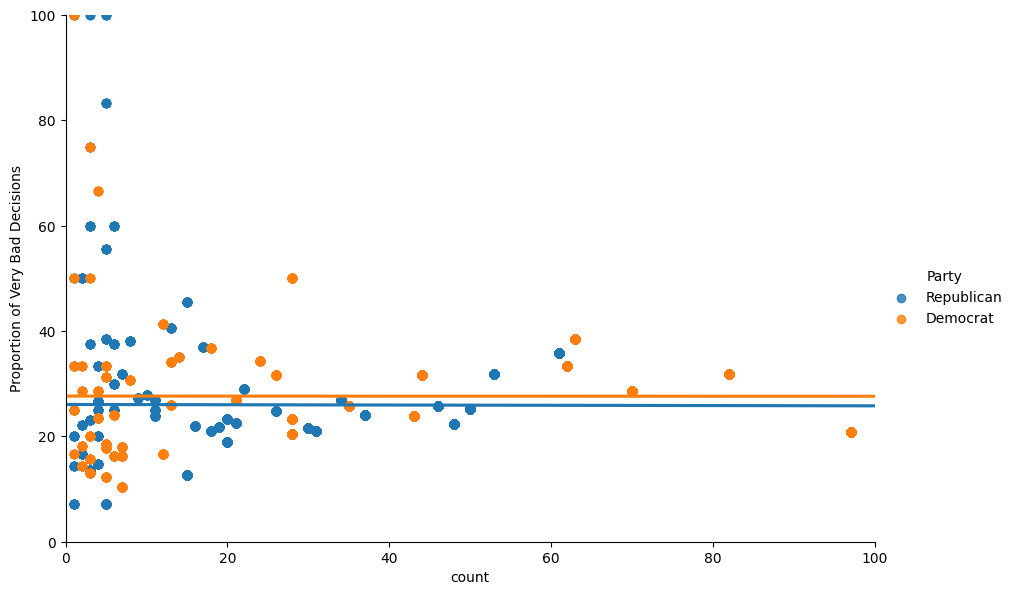

In [239]:
plot_data = palt[palt['transaction_eval'] == 'Very Bad Decision'].sort_values('proportion', ascending=False)
sns.lmplot(data=plot_data, x='count', y='proportion', hue='Party', truncate=False, height=6, aspect=1.5)

plt.xlim(0, 100)
plt.ylim(0, 100)
plt.ylabel('Proportion of Very Bad Decisions')
plt.show()